In [1]:
import numpy as np
from time import time
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
from theano import function, shared
from theano.tensor.extra_ops import repeat, to_one_hot
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


### Study the processes and variables needed for theano implementation of variational inference on the probe model
Here I built and tested most of the machinery needed to 

#### Dimensions

In [2]:
floatX = 'float32'
sqrt_D = 32
D = int(sqrt_D*sqrt_D)#number of pixels
K = 8#number of objects
N = 200#number of windows (data points)
M = 10#number of object map samples to generate for calculating object responsibility

#### Generate samples of object maps from a posterior over object maps

In [3]:
##the variational posterior over object maps Z
_Q_Z = T.matrix('Q_Z') ##(K,D)
_M = T.scalar('M',dtype='int32')

##a theano random number generator
rng = MRG_RandomStreams(use_cuda = True)

##sample one Z map from posterior Q_Z
_Z_samples = rng.multinomial(pvals = repeat(_Q_Z.T,_M,axis=0)).reshape((_Q_Z.shape[1],_M,_Q_Z.shape[0])).dimshuffle((1,2,0))

##functionalize
Z_sample_func = function([_Q_Z,_M],outputs=_Z_samples)

In [4]:
##to test first generate posterior from a dirichlet distribution
alpha_0 = 1.1
Q_Z = np.zeros((K,D), dtype=floatX)
probs = np.random.dirichlet([alpha_0]*K,)
for d in range(D): #np.random.permutation(D):
    if not np.mod(d,64):
        probs = np.random.dirichlet([alpha_0]*K,)
    Q_Z[:,d] = probs
print np.sum(Q_Z,axis=0)

[ 0.99999994  0.99999994  0.99999994 ...,  1.          1.          1.        ]


In [5]:
##this shows the how the crazy tensor manipulation is working
r_shuff = function([_Q_Z, _M], outputs = repeat(_Q_Z.T,_M,axis=0).reshape((_Q_Z.shape[1],_M,_Q_Z.shape[0])).dimshuffle((1,2,0)))

In [6]:
##this will help visualize
def from_one_hot(Z,axis=0):
    '''
    Z ~ K x D
    convert to 1 x D, D[i] = j, j = argmax(Z[:,i])
    '''
    return np.argmax(Z,axis=axis)

In [7]:
##generate M sample maps (M x K x D)
Z_samples = Z_sample_func(Q_Z, M)

(10, 8, 1024)


/home/tnaselar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


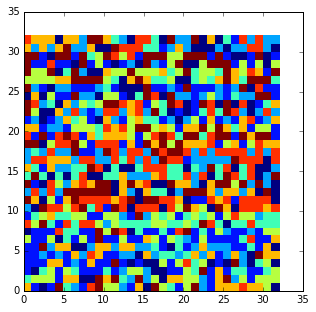

In [8]:
print Z_samples.shape
fig = plt.figure(figsize=(5,5))
plt.pcolor(from_one_hot(Z_samples[0]).reshape(np.sqrt(D),np.sqrt(D)))

#### The object responsibility matrix (i.e., N x K matrix of object count probabilities, N = #windows, K = #possible object counts)
TODO: THIS COMPUTATION IS WAY TOO GODDAMN SLOW.

In [9]:
##block of sampled object maps
_Z = T.tensor3('Z') ##(M x K x D)

##window index indicator (N X D)
_W = T.matrix('windows')


An expression for an (M,N) matrix of objects counts

In [10]:
##(M x K x 1 x D)
##         N x D
##(M x K x N x D)  sum(D)
##(M x K x N)      clip(0,1)
##(M x K x N)      sum(K)
##(M x N)
_O_W = T.sum(_Z.dimshuffle((0,1,'x',2))*_W,axis=-1).clip(0,1).sum(axis=1)

In [11]:
window_object_count_func = function([_Z,_W], outputs=_O_W)

In [12]:
##construct some contiguous windows of varying size
W = np.zeros((N,D),dtype=floatX)
win_stride = np.round(D/N)
size_factor = 2
for n in range(N):
    W[n,(n*win_stride):(n*win_stride+size_factor*n+1)] = 1

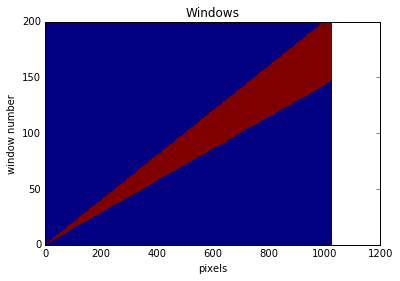

In [13]:
plt.pcolor(W)
plt.title('Windows')
plt.xlabel('pixels')
plt.ylabel('window number')

In [14]:
foo = window_object_count_func(Z_samples.astype(floatX),W)

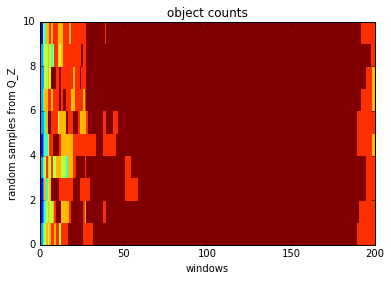

In [15]:
plt.pcolor(foo)
plt.title('object counts')
plt.xlabel('windows')
plt.ylabel('random samples from Q_Z')

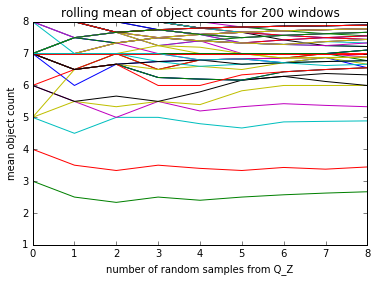

In [16]:
##calculate rolling mean 
rolling_mean = np.zeros((M,N))
for m in range(M-1):
    rolling_mean[m,:] = np.mean(foo[:m+1, :], axis=0)

_=plt.plot(rolling_mean[0:-1,:])
plt.title('rolling mean of object counts for %d windows' %(N))
plt.xlabel('number of random samples from Q_Z')
plt.ylabel('mean object count')

Test out one-hot encoding of the object counts (M, N, K)

In [17]:
X = T.matrix(dtype='int32')
object_count_one_hot_func = function([X],to_one_hot(X.flatten()-1,K).reshape((X.shape[0],X.shape[1],K)))

In [18]:
baz = object_count_one_hot_func(foo.astype('int32'))

In [19]:
foo[:,12]

array([ 5.,  8.,  7.,  6.,  7.,  6.,  8.,  8.,  5.,  6.], dtype=float32)

In [20]:
baz[:,12,:]

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

Having tested the one-hot encoding, we sum across samples and divide to obtain object count probabilities (i.e., the "object responsibility matrix").

In [21]:
_K = T.scalar('objects',dtype='int32')
_R_nn = to_one_hot(_O_W.astype('int32').flatten()-1,_K).reshape((_O_W.shape[0],_O_W.shape[1],_K)).sum(axis=0)

In [22]:
non_norm_resp_func = function([_Z, _W, _K], outputs = _R_nn)

In [23]:
non_norm_resp = non_norm_resp_func(Z_samples.astype(floatX),W,K)

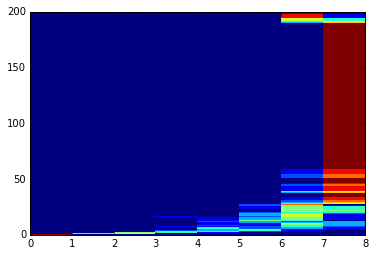

In [24]:
plt.pcolor(non_norm_resp)

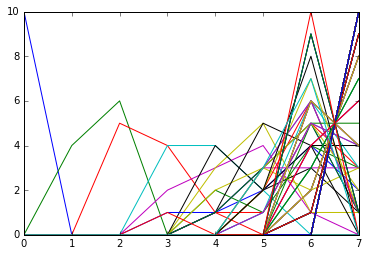

In [25]:
_=plt.plot(non_norm_resp.T)

In [26]:
##normalize
_R = _R_nn / _R_nn.sum(axis=1).reshape((_R_nn.shape[0], 1))

In [27]:
##object count probabilities function
object_count_prob_func = function([_Z, _W, _K], outputs = _R)

In [28]:
oc = object_count_prob_func(Z_samples.astype(floatX),W,K)

In [29]:
oc.shape

(200, 8)

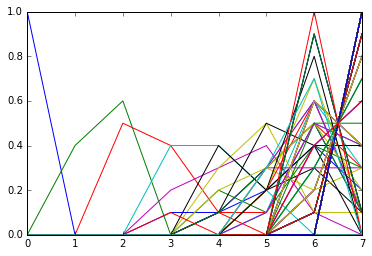

In [30]:
_=plt.plot(oc.T)

In [31]:
##some timing info--how long for one full sweep of calls for each pixel/object pair?
Z_samples = Z_samples.astype(floatX)
start = time()
for d in range(D):
    if not np.mod(d, np.round(D/12.)):
        print '%d pixels remaining' %(D-d)
    for k in range(K):
        _=object_count_prob_func(Z_samples,W,K)
end = time()-start
print end

1024 pixels remaining
939 pixels remaining
854 pixels remaining
769 pixels remaining
684 pixels remaining
599 pixels remaining
514 pixels remaining
429 pixels remaining
344 pixels remaining
259 pixels remaining
174 pixels remaining
89 pixels remaining
4 pixels remaining
26.9483549595


In [32]:
2*26*1000/60./60.

14.444444444444445

#### Likelihood function and parameter updates

In [33]:
from imagery_psychophysics.src.model_z import noise_grid
from scipy.misc import comb as nCk

In [34]:
def counts(r,d,n):
    return np.array([nCk(d,m)*nCk(n-d, r-m) for m in range(min(r,d)+1)])

def lkhd(r,d,n,p_on,p_off):
    probs = np.array([(1-p_on)**(d-m) * (p_on)**m * (p_off)**(r-m) * (1-p_off)**(n-d-r+m) for m in range(min(r,d)+1)])
    #print probs
    return counts(r,d,n).dot(probs)

Critical tensor is the likelihoods iterated over a fine grid of noise parameters


In [36]:
theta_dns = 25
p_on, p_off = noise_grid(theta_dns,theta_dns)
G = len(p_on)
P_theta = np.zeros((G, N, K),dtype=floatX)
r = np.random.randint(1,high=K+1, size=(N,))

/musc.repo/Docs/tnaselar/code/Python/imagery_psychophysics/src/model_z.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  p_on =  [np.array([ii]*np.max([np.ceil(D*ii),1])) for ii in np.linspace(small,1,dns)]


In [37]:
##fortunately we only need to generate this once.
for g,p in enumerate(zip(p_on,p_off)):
    for n in range(N):
        for k in range(K):
            P_theta[g,n,k]  = lkhd(r[n],k+1,K, p[0],p[1])

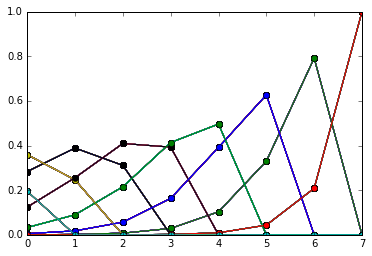

In [38]:
_=plt.plot(P_theta[-20].T, '-o')

This is the simple update rule for the variational log posterior over theta (i.e., the noise parameters). It's understood that this is technically $ln[q(\theta)] - const$

Note also that we probably won't be needing the $ln[q(\theta)]$ output, but we emit it anyway

In [39]:


_P_theta = T.tensor3('P_theta') ##(G x N x K)
_X = T.matrix('dummy')

##(G x N x K)
##(    N x K)  (dot product, broadcast across G)
_lnQ_theta = T.tensordot(T.log(_P_theta),_X, axes=[[1,2], [0,1]])

In [40]:
lnQ_theta_update_func = function([_P_theta, _X], outputs = _lnQ_theta)

In [41]:
lnQ_theta_update_func(np.random.random((G,N,K)).astype(floatX), np.random.random((N,K)).astype(floatX)).shape

(325,)

In [42]:
#select the best noise params
_P_star = _P_theta[T.argmax(_lnQ_theta),:,:]

In [43]:
P_star_update_func = function([_P_theta, _X], outputs = _P_star)

In [44]:
foo = P_star_update_func(P_theta, np.random.random((N,K)).astype(floatX))
print foo.shape

(200, 8)


In [45]:
##put the lnQ_theta and lnP_star updates into same handy function
theta_update_func = function([_P_theta,_X], outputs = [_lnQ_theta, _P_star])

In [46]:
lnQ_theta, P_star = theta_update_func(P_theta, np.random.random((N,K)).astype(floatX))

In [47]:
print lnQ_theta.shape ##(G,)
print P_star.shape  ##(N , K)

(325,)
(200, 8)


#### Prior over object maps
Main quantity of interest here is $\mathbb{E}[ln[\pi]$. 

In [48]:
_alpha_0 = T.scalar('alpha_0')
_q_Z = T.vector('q_Z')  ##1 x K, this is result of summing over pixels in Q_Z matrix

_alpha = _q_Z + _alpha_0 ##broadcasts the scalar _alpha_0 across K

_Eln_pi = T.psi(_alpha) - T.psi(_alpha.sum())

In [49]:
Eln_pi_update_func = function([_q_Z, _alpha_0], outputs = _Eln_pi)

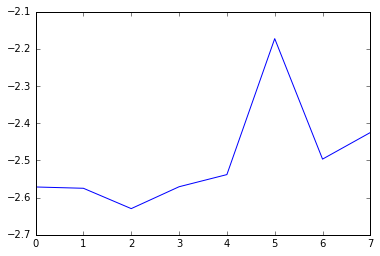

In [50]:
alpha_0 = 1.1
q_Z = np.random.dirichlet([alpha_0]*K,).astype(floatX) ##a fake q_Z

Eln_pi = Eln_pi_update_func(q_Z, alpha_0)
plt.plot(Eln_pi)

#### Update variational posterior for object maps
UGH!: DIMENSIONS ARE WRONG! SHOULD BE K x D, *not* D x K

This will be the only update that returns a normalized variational posterior.
Uses the responsibility matrices above.


In [51]:
_R_full = T.tensor4('responsibility_tensor') ##D x K x N x K
_lnP_star = T.matrix('lnP_star') ##N x K
_V = T.matrix('prior_penalties') ## D x K

##D x K x N x K
##        N x K (dot)
##D x K         (add V)
##D x K         exp
##D x K         normalize

_lnQ_Z_nn = T.tensordot(_R_full, _lnP_star, [[2,3], [0,1]])+_V
_Q_Z_nn = T.exp(_lnQ_Z_nn+T.max(T.abs_(_lnQ_Z_nn)))
_Q_Z = _Q_Z_nn / _Q_Z_nn.sum(axis=1).reshape((_Q_Z_nn.shape[0], 1))

In [52]:
Q_Z_update_func = function([_R_full, _lnP_star, _V], outputs=[_Q_Z, _Q_Z_nn])

In [53]:
##some timing info--how long for one full sweep of calls for each pixel/object pair?
R_full = np.zeros((D,K,N,K),dtype=floatX)
lnP_star = np.log(P_star).astype(floatX)
V = np.random.random(size=(D,K)).astype(floatX)+alpha_0
start = time()
for d in range(D):
    if not np.mod(d, np.round(D/12.)):
        print '%d pixels remaining' %(D-d)
    for k in range(K):
        R_full[d,k,:,:] =object_count_prob_func(Z_samples,W,K)
Q_Z_new, foo = Q_Z_update_func(R_full, lnP_star, V)
end = time()-start
print end

1024 pixels remaining
939 pixels remaining
854 pixels remaining
769 pixels remaining
684 pixels remaining
599 pixels remaining
514 pixels remaining
429 pixels remaining
344 pixels remaining
259 pixels remaining
174 pixels remaining
89 pixels remaining
4 pixels remaining
26.7333519459


In [54]:
Q_Z_new, foo = Q_Z_update_func(R_full, lnP_star, V)

In [93]:
Q_Z_new.shape

(1024, 8)

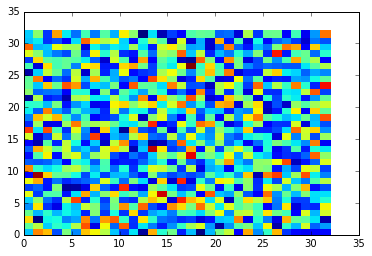

In [55]:
_=plt.pcolor(Q_Z_new[:,4].reshape(sqrt_D,sqrt_D))

#### Expressions for the ELBO
I suppose this is an approximate ELBO since we are using a $max \approx expectation$ approximation for $\theta$.

In [56]:
_Eln_pi = T.vector('Eln_pi')  ##1 x K
_Q_Z = T.matrix('Q_Z')        ##D x K
_lnQ_theta = T.vector('lnQ_theta') ##1 x G

_q_Z = _Q_Z.sum(axis=0)

In [57]:
_prior_entropy = -T.dot(_q_Z-1, _Eln_pi)-(T.gammaln(_q_Z.sum()) - T.sum(T.gammaln(_q_Z)))
_posterior_entropy = -T.tensordot(_Q_Z, T.log(_Q_Z)) 

In [58]:
_ELBO = _lnQ_theta.max()  - _posterior_entropy - _prior_entropy

In [59]:
ELBO_update_func = function([_Eln_pi, _Q_Z, _lnQ_theta], outputs=_ELBO)

In [60]:
ELBO = ELBO_update_func(Eln_pi, Q_Z_new, lnQ_theta)

In [61]:
ELBO

array(-4594.958984375, dtype=float32)

Well. The sign is right. We'll see if it makes any sense...

#### Simulate data

In [62]:
from imagery_psychophysics.src.stirling_maps import sparse_point_maps as spm

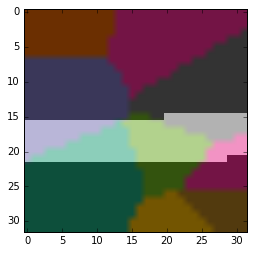

In [63]:
##construct a test object map
test_object_map = spm(3,3,sqrt_D,cluster_pref = 'random',number_of_clusters = K)
test_object_map.scatter()
test_object_map = np.squeeze(test_object_map.nn_interpolation())
plt.imshow(test_object_map, cmap='Dark2')
plt.imshow(W[100].reshape((sqrt_D,sqrt_D)).astype('uint8')*255, interpolation='nearest', alpha = .5, cmap=plt.cm.gray, clim=[0,255])

In [64]:
##convert to one_hot encoding
test_Z = np.eye(K)[test_object_map.ravel()-1].T  ##K x D
d = 19
print test_object_map[d,d]
print test_Z.reshape((K,sqrt_D,sqrt_D))[:,d,d]

5
[ 0.  0.  0.  0.  1.  0.  0.  0.]


In [65]:
##get true object counts for each window
object_counts = np.sum(test_Z[:,np.newaxis,:]*W,axis=-1).clip(0,1).sum(axis=0).astype('int')
object_counts[100]

5

In [66]:
object_counts.dtype

dtype('int64')

In [67]:
##generate some fake responses using fixed theta parameters
p_on = 0.9
p_off = 0.1
r = np.zeros(object_counts.shape[0], dtype = 'int')
for ii,o in enumerate(object_counts):
    resp_dist = np.zeros(K)
    for k in range(K):
        resp_dist[k] = lkhd(k+1,o,K,p_on,p_off)
        r[ii]=np.argmax(np.random.multinomial(1,resp_dist))+1


In [68]:
np.abs(r-object_counts)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 2,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2,
       1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 3, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0])

In [69]:
np.mean(np.abs(r-object_counts))

0.55500000000000005

#### Complete loop for variational dynamics

In [87]:
##to test first generate posterior from a dirichlet distribution

alpha_0 = 1.1
p_on, p_off = .9, .1

def init_Q():
    Q_Z = np.zeros((K,D), dtype=floatX)
    probs = np.random.dirichlet([alpha_0]*K,)
    for d in range(D): #np.random.permutation(D):
        if not np.mod(d,64):
            probs = np.random.dirichlet([alpha_0]*K,)
        Q_Z[:,d] = probs
    return Q_Z

def init_Eln_pi():
    q_Z = np.random.dirichlet([alpha_0]*K,).astype(floatX) ##a fake q_Z
    Eln_pi = Eln_pi_update_func(q_Z, alpha_0)
    return Eln_pi

def init_P_star():
    P_theta = np.zeros((N,K),dtype=floatX)
    for n in range(N):
        for k in range(K):
            P_theta[n,k]  = lkhd(r[n],k+1,K, p_on,p_off)
    return P_theta


R_full = np.zeros((D,K,N,K),dtype=floatX)
V = np.zeros((D,K),dtype=floatX)

def p_Z(lnP_star, Eln_pi): 
    for d in range(D):
        if not np.mod(d, np.round(D/12.)):
            print '%d pixels remaining' %(D-d)
        for k in range(K):
            Z = Z_samples.copy()
            Z[:,:,d] = 0.
            Z[:,k, d] = 1.
            R_full[d,k,:,:] =object_count_prob_func(Z,W,K).astype(floatX)
            V[d,k] = np.dot(Z[0,:,d], Eln_pi)
    Q_Z_new, _ = Q_Z_update_func(R_full, lnP_star, V)
    return Q_Z_new

Q_Z = init_Q()
Eln_pi = init_Eln_pi()
P_star = init_P_star()

ELBO = -np.inf
delta_ELBO = np.inf





In [88]:
Eln_pi.shape

(8,)

In [89]:
t = 0
max_T = 10
ELBO = np.zeros(max_T)
while (delta_ELBO > 0) and (t < max_T):
    print 'iteration: %d' %(t,)
    Z_samples = Z_sample_func(Q_Z, M).astype(floatX)
    lnP_star = np.log(P_star).astype(floatX)
    Q_Z = p_Z(lnP_star, Eln_pi.astype(floatX))
    Z_new = Z_sample_func(Q_Z, M).astype(floatX)
    R = object_count_prob_func(Z_new, W, K)
    lnQ_theta, P_star_new = theta_update_func(lnP_star, R)
    Eln_pi = Eln_pi_update_func(Q_Z.sum(axis=1), alpha_0)
    ELBO[t] = ELBO_update_func(Eln_pi, Q_Z, lnQ_theta)
    print '============ELBO: %f' %(ELBO[t])
    t += 1

iteration: 0
1024 pixels remaining
939 pixels remaining
854 pixels remaining
769 pixels remaining
684 pixels remaining
599 pixels remaining
514 pixels remaining
429 pixels remaining
344 pixels remaining
259 pixels remaining
174 pixels remaining
89 pixels remaining
4 pixels remaining


ValueError: GpuElemwise. Input dimension mis-match. Input 1 (indices start at 0) has shape[3] == 1024, but the output's size on that axis is 8.
Apply node that caused the error: GpuElemwise{mul,no_inplace}(GpuDimShuffle{0,1,x,2}.0, GpuDimShuffle{x,x,0,1}.0)
Toposort index: 14
Inputs types: [CudaNdarrayType(float32, (False, False, True, False)), CudaNdarrayType(float32, (True, True, False, False))]
Inputs shapes: [(10, 1024, 1, 8), (1, 1, 200, 1024)]
Inputs strides: [(8192, 8, 0, 1), (0, 0, 1024, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuReshape{2}(GpuElemwise{mul,no_inplace}.0, MakeVector{dtype='int64'}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [91]:
Z_samples.shape

(10, 8, 1024)

In [92]:
Q_Z.shape

(1024, 8)